In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
from ops.os_operation import mkdir
import shutil
import  numpy as np
from data_processing.Prepare_Input import Prepare_Input
from data_processing.Single_Dataset import Single_Dataset
from torch.utils.data import DataLoader
from data_processing.collate_fn import collate_fn_Jake
from torch.utils.data import DataLoader
import pickle

In [41]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import time
from multiprocessing import Pool
from model.layers import GAT_gate

N_atom_features = 28

class GNN_Model(nn.Module):
    def __init__(self, params):
        super(GNN_Model, self).__init__()
        n_graph_layer = params['n_graph_layer']
        d_graph_layer = params['d_graph_layer']
        n_FC_layer = params['n_FC_layer']
        d_FC_layer = params['d_FC_layer']
        self.dropout_rate = params['dropout_rate']


        self.layers1 = [d_graph_layer for i in range(n_graph_layer +1)]
        self.gconv1 = nn.ModuleList \
            ([GAT_gate(self.layers1[i], self.layers1[ i +1]) for i in range(len(self.layers1 ) -1)])

#         Original
#         self.FC = nn.ModuleList([nn.Linear(self.layers1[-1], d_FC_layer) if i== 0 else
#                                  nn.Linear(d_FC_layer, 1) if i == n_FC_layer - 1 else
#                                  nn.Linear(d_FC_layer, d_FC_layer) for i in range(n_FC_layer)])

#         Jake params 1
#         self.FC = nn.ModuleList([nn.Linear(self.layers1[-1], 300),
#                                  nn.Linear(300, 200),
#                                  nn.Linear(200, 1)
#                                  ])

#         Jake params 2
        self.FC = nn.ModuleList([nn.Linear(self.layers1[-1], 2048),
                                 nn.Linear(2048, 512),
                                 nn.Linear(512, 256),
                                 nn.Linear(256, 1)
                                 ])

#         Jake params 3
#         self.FC = nn.ModuleList([nn.Linear(self.layers1[-1], 2048),
#                                  nn.Linear(2048, 512),
#                                  nn.Linear(512, 256),
#                                  nn.Linear(256, 1)
#                                  ])

        self.mu = nn.Parameter(torch.Tensor([params['initial_mu']]).float())
        self.dev = nn.Parameter(torch.Tensor([params['initial_dev']]).float())
        #self.embede = nn.Linear(2 * N_atom_features, d_graph_layer, bias=False)
        self.params=params



    def fully_connected(self, c_hs):
        regularization = torch.empty(len(self.FC) * 1 - 1, device=c_hs.device)
        act_fn = nn.LeakyReLU(0.2)

        for k in range(len(self.FC)):
            # c_hs = self.FC[k](c_hs)
            if k < len(self.FC) - 1:
                c_hs = self.FC[k](c_hs)
                c_hs = F.dropout(c_hs, p=self.dropout_rate, training=self.training)
                # c_hs = F.relu(c_hs)
                c_hs = act_fn(c_hs)
            else:
                c_hs = self.FC[k](c_hs)

        c_hs = torch.sigmoid(c_hs)

        return c_hs
    def Formulate_Adj2(self,c_adjs2,c_valid,atom_list,device):
        study_distance = c_adjs2.clone().detach().to(device)  # only focused on where there exist atoms, ignore the area filled with 0
        study_distance = torch.exp(-torch.pow(study_distance - self.mu.expand_as(study_distance), 2) / self.dev)
        filled_value = torch.Tensor([0]).expand_as(study_distance).to(device)
        for batch_idx in range(len(c_adjs2)):
            num_atoms = int(atom_list[batch_idx])
            count_receptor = len(c_valid[batch_idx].nonzero())
            c_adjs2[batch_idx,:count_receptor,count_receptor:num_atoms]=torch.where(c_adjs2[batch_idx,:count_receptor,count_receptor:num_atoms]<=20,study_distance[batch_idx,:count_receptor,count_receptor:num_atoms],filled_value[batch_idx,:count_receptor,count_receptor:num_atoms])
            c_adjs2[batch_idx,count_receptor:num_atoms,:count_receptor]=c_adjs2[batch_idx,:count_receptor,count_receptor:num_atoms].t()
        return c_adjs2

    def get_attention_weight(self,data):
        c_hs, c_adjs1, c_adjs2 = data
        atten1,c_hs1 = self.gconv1[0](c_hs, c_adjs1,request_attention=True)  # filled 0 part will not effect other parts
        atten2,c_hs2 = self.gconv1[0](c_hs, c_adjs2,request_attention=True)
        return atten1,atten2
    def embede_graph(self, data):
        """

        :param data:
        :return: c_hs:batch_size*max_atoms
        """
        c_hs, c_adjs1, c_adjs2= data
        regularization = torch.empty(len(self.gconv1), device=c_hs.device)

        for k in range(len(self.gconv1)):
            c_hs1 = self.gconv1[k](c_hs, c_adjs1)#filled 0 part will not effect other parts
            c_hs2 = self.gconv1[k](c_hs, c_adjs2)
            c_hs = c_hs2 - c_hs1
            c_hs = F.dropout(c_hs, p=self.dropout_rate, training=self.training)
        #c_hs = c_hs.sum(1)
        return c_hs
    def Get_Prediction(self,c_hs,atom_list):
        prediction=[]
        for batch_idx in range(len(atom_list)):
            num_atoms = int(atom_list[batch_idx])
            tmp_pred=c_hs[batch_idx,:num_atoms]
            
            ## POOLING METHOD:
            # tmp_pred=tmp_pred.sum(0)#sum all the used atoms
            tmp_pred=tmp_pred.mean(0) ## Average all the used atoms
            
            
            #if self.params['debug']:
            #    print("pred feature size",tmp_pred.size())
            prediction.append(tmp_pred)
        prediction = torch.stack(prediction, 0)
        return prediction
    def train_model(self,data,device):
        #get data
        c_hs, c_adjs1, c_adjs2, c_valid, num_atoms = data
        #c_hs = self.embede(c_hs)
        c_adjs2=self.Formulate_Adj2(c_adjs2,c_valid,num_atoms,device)
        #then do the gate
        c_hs=self.embede_graph((c_hs,c_adjs1,c_adjs2))
        #if self.params['debug']:
        #    print("embedding size",c_hs.size())
        #sum based on the atoms
        c_hs=self.Get_Prediction(c_hs,num_atoms)
        c_hs = self.fully_connected(c_hs)
        c_hs = c_hs.view(-1)
        return c_hs
    def test_model(self, data,device):
        c_hs, c_adjs1, c_adjs2, c_valid, num_atoms = data
        #c_hs = self.embede(c_hs)
        c_adjs2 = self.Formulate_Adj2(c_adjs2, c_valid, num_atoms,device)
        # then do the gate
        c_hs = self.embede_graph((c_hs, c_adjs1, c_adjs2))
        # sum based on the atoms
        c_hs = self.Get_Prediction(c_hs, num_atoms)
        c_hs = self.fully_connected(c_hs)
        c_hs = c_hs.view(-1)
        return c_hs
    def test_model_final(self,data,device):
        c_hs, c_adjs1, c_adjs2, c_valid, num_atoms = data
        #c_hs = self.embede(c_hs)
        c_adjs2 = self.Formulate_Adj2(c_adjs2, c_valid, num_atoms, device)
        attention1, attention2 = self.get_attention_weight((c_hs, c_adjs1, c_adjs2))
        # then do the gate
        c_hs = self.embede_graph((c_hs, c_adjs1, c_adjs2))
        # sum based on the atoms
        c_hs = self.Get_Prediction(c_hs, num_atoms)
        c_hs = self.fully_connected(c_hs)
        c_hs = c_hs.view(-1)
        return c_hs,attention1,attention2
    def eval_model_attention(self,data,device):
        c_hs, c_adjs1, c_adjs2, c_valid, num_atoms = data
        #c_hs = self.embede(c_hs)
        c_adjs2 = self.Formulate_Adj2(c_adjs2, c_valid, num_atoms, device)
        attention1,attention2 = self.get_attention_weight((c_hs, c_adjs1, c_adjs2))
        return attention1,attention2
    def feature_extraction(self,c_hs):
        for k in range(len(self.FC)):
                # c_hs = self.FC[k](c_hs)
            if k < len(self.FC) - 1:
                c_hs = self.FC[k](c_hs)
                c_hs = F.dropout(c_hs, p=self.dropout_rate, training=False)
                c_hs = F.relu(c_hs)

            return c_hs
    def model_gnn_feature(self, data,device):
        c_hs, c_adjs1, c_adjs2, c_valid, num_atoms = data
        #c_hs = self.embede(c_hs)
        c_adjs2 = self.Formulate_Adj2(c_adjs2, c_valid, num_atoms,device)
        # then do the gate
        c_hs = self.embede_graph((c_hs, c_adjs1, c_adjs2))
        # sum based on the atoms
        c_hs = self.Get_Prediction(c_hs, num_atoms)
        #c_hs = self.fully_connected(c_hs)
        #c_hs = c_hs.view(-1)
        c_hs=self.feature_extraction(c_hs)
        return c_hs

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def initialize_model(model, device, load_save_file=False):
    if load_save_file:
        model.load_state_dict(torch.load(load_save_file))
    else:
        for param in model.parameters():
            if param.dim() == 1:
                continue
                nn.init.constant(param, 0)
            else:
                #nn.init.normal(param, 0.0, 0.15)
                nn.init.xavier_normal_(param)

    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model)
    model.to(device)
    return model

def init_model(model_path,params):
    model = GNN_Model(params)
    print('    Total params: %.10fM' % (count_parameters(model) / 1000000.0))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = initialize_model(model, device)
    state_dict = torch.load(model_path, map_location = device)
    model.load_state_dict(state_dict)
    model.eval()
    return model,device

In [6]:
def Get_Predictions(dataloader,device,model):
    Final_pred = []
    total_Y = []
    with torch.no_grad():
        for batch_idx, sample in enumerate(dataloader):
            H, A1, A2, V, Y, Atom_count = sample
            batch_size = H.size(0)
            H, A1, A2, V = H.to(device), A1.to(device), A2.to(device), V.to(device)
            pred= model.test_model((H, A1, A2, V, Atom_count), device)
            pred1 = pred.detach().cpu().numpy()
            Final_pred += list(pred1)
            total_Y += list(Y)
    return total_Y, Final_pred

def test_falcon_gnn(input_path, params, model_path):
    '''
    Trains the GNN according to Jake's parameters.
    FALCON_GNN stands for Fucking Awesome Linking
    Cohort Of Nottingham, which I just made up
    '''
    ## Get all the NPZ files from the input_path

    list_npz = [f for f in listdir(input_path) if isfile(join(input_path, f)) and f.endswith(".npz")]
    fold1_label = ['1a2k', '1e96', '1he1', '1he8', '1wq1', '1f6m', '1ma9', '2btf', '1g20', '1ku6', '1t6g', '1ugh', '1yvb', '2ckh', '3pro']
    fold2_label = ['1akj', '1p7q', '2bnq', '1dfj', '1nbf', '1r4m', '1xd3', '2bkr', '1gpw', '1hxy', '1u7f', '1uex', '1zy8', '2goo', '1ewy']
    fold3_label = ['1avw', '1bth', '1bui', '1cho', '1ezu', '1ook', '1oph', '1ppf', '1tx6', '1xx9', '2fi4', '2kai', '1r0r', '2sni', '3sic']
    fold4_label = ['1bvn', '1tmq', '1f51', '1fm9', '1a2y', '1g6v', '1gpq', '1jps', '1wej', '1l9b', '1s6v', '1w1i', '2a5t', '3fap']

    train_data_list = []
    test_data_list = []
    print(len(list_npz))
    for file in list_npz:
        if file[:4] in fold1_label or file[:4] in fold3_label or file[:4] in fold4_label:
            train_data_list.append(file)
        elif file[:4] in fold2_label:
            test_data_list.append(file)
    
    ## Just to test it out
#     test_data_list = test_data_list[:120]
    
    train_data = Single_Dataset(train_data_list)
    test_data = Single_Dataset(test_data_list)
    #train_data, test_data = random_split(dataset, [0.75, 0.25])

    BATCH_SIZE = 10

    train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=False,
                            num_workers=params['num_workers'],
                            drop_last=False, collate_fn=collate_fn_Jake)

    test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False,
                            num_workers=params['num_workers'],
                            drop_last=False, collate_fn=collate_fn_Jake)

    ## Initialize Model from saved state
    
    model, device = init_model(model_path, params)
    
    ## Get predictions for the model
    
    os.chdir(input_path)
    Y, Final_Pred = Get_Predictions(test_loader, device, model)
     
    return test_data_list, Final_Pred, Y

## Actually testing the model

In [10]:
## Original DOVE GNN Parameters

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 4,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/full_train_DG1_random_batch_orig_params.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list, preds, y = test_falcon_gnn(input_path, params, model_path)

6275
    Total params: 8.5652550000M


In [16]:
## Jake Parameters 1

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/full_train_DG1_random_batch_jake_params_1.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list_1, preds_1, y_1 = test_falcon_gnn(input_path, params, model_path)

6275
    Total params: 6.6685780000M


In [20]:
## Jake Parameters 2

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/full_train_DG1_random_batch_jake_params_2.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list_2, preds_2, y_2 = test_falcon_gnn(input_path, params, model_path)

6275
    Total params: 9.5805500000M


In [22]:
## Jake Parameters 3

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/full_train_DG1_random_batch_jake_params_3.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list_3, preds_3, y_3 = test_falcon_gnn(input_path, params, model_path)

6275
    Total params: 9.5805500000M


## Assessing the Top Ranks of the Models

In [34]:
## Some functions to help with everything
def get_ordered_list(test_list, preds, y):
    '''
    Works to get the ordered and grouped list 
    to make analysis easier
    '''
    curr_pdb = ''
    ordered_test_list = []
    temp_pdb_list = []
    for i,ele in enumerate(test_list):
        if ele[:4] != curr_pdb:
            ## Reset the vars for the next pdb set
            curr_pdb = ele[:4]
            temp_pdb_list.sort()
            ordered_test_list.append(temp_pdb_list[::-1])
            temp_pdb_list = []
        temp_pdb_list.append((preds[i], ele.split(".")[0], int(y[i])))

    ordered_test_list = ordered_test_list[1:]
    return ordered_test_list

In [35]:
## Getting the top ranks the same way that DOVE_GNN does

def get_ranks(ordered_test_list):
    '''
    Gets the top ranks the same way the DOVE GNN does
    '''
    rank_list = []
    for group in ordered_test_list:
        first_rank = 0
        group_name = group[0][1][:4]
        for i, entry in enumerate(group):
            if entry[2] == 1:
                rank_list.append((group_name, i+1))
                break
    return rank_list

In [36]:
## Calculating the Top Ranks:

orig_ranks = get_ranks(get_ordered_list(test_list, preds, y))
jake1_ranks = get_ranks(get_ordered_list(test_list_1, preds_1, y_1))
jake2_ranks = get_ranks(get_ordered_list(test_list_2, preds_2, y_2))
jake3_ranks = get_ranks(get_ordered_list(test_list_3, preds_3, y_3))

In [37]:
print(orig_ranks)

[('1akj', 1), ('1dfj', 1), ('1ewy', 1), ('1gpw', 1), ('1hxy', 1), ('1nbf', 1), ('1p7q', 1), ('1r4m', 1), ('1u7f', 1), ('1uex', 1), ('1xd3', 1), ('1zy8', 1), ('2bkr', 1), ('2bnq', 1)]


In [38]:
print(jake1_ranks)

[('1akj', 1), ('1dfj', 1), ('1ewy', 1), ('1gpw', 1), ('1hxy', 1), ('1nbf', 1), ('1p7q', 1), ('1r4m', 1), ('1u7f', 1), ('1uex', 1), ('1xd3', 1), ('1zy8', 1), ('2bkr', 1), ('2bnq', 1)]


In [39]:
print(jake2_ranks)

[('1akj', 1), ('1dfj', 79), ('1ewy', 3), ('1gpw', 66), ('1hxy', 1), ('1nbf', 1), ('1p7q', 1), ('1r4m', 6), ('1u7f', 2), ('1uex', 2), ('1xd3', 1), ('1zy8', 3), ('2bkr', 1), ('2bnq', 1)]


In [40]:
print(jake3_ranks)

[('1akj', 2), ('1dfj', 64), ('1ewy', 3), ('1gpw', 19), ('1hxy', 2), ('1nbf', 8), ('1p7q', 1), ('1r4m', 22), ('1u7f', 2), ('1uex', 17), ('1xd3', 6), ('1zy8', 1), ('2bkr', 4), ('2bnq', 1)]


## Looking at Loss

In [48]:
os.chdir("/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/")
loss_orig = pickle.load(open("full_train_DG1_random_batch_orig_params_loss.pickle", "rb"))
loss_jake_1 = pickle.load(open("full_train_DG1_random_batch_jake_params_1_loss.pickle", "rb"))
loss_jake_2 = pickle.load(open("full_train_DG1_random_batch_jake_params_2_loss.pickle", "rb"))
loss_jake_3 = pickle.load(open("full_train_DG1_random_batch_jake_params_3_loss.pickle", "rb"))

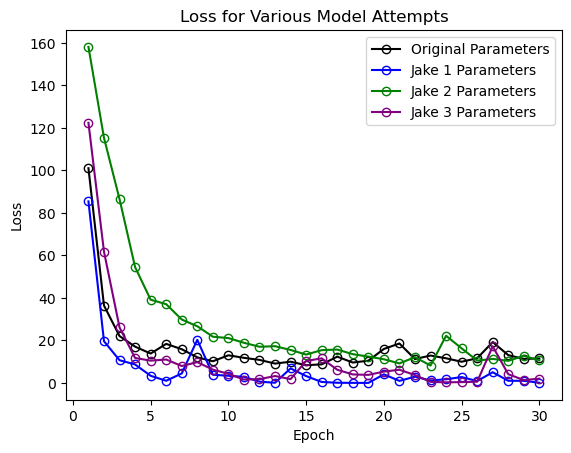

In [50]:
fig, ax = plt.subplots()

x_axis = range(1,31)
ax.plot(x_axis, loss_orig, label = "Original Parameters", color = "black", marker = "o", markerfacecolor = "None")
ax.plot(x_axis, loss_jake_1, label = "Jake 1 Parameters", color = "blue", marker = "o", markerfacecolor = "None")
ax.plot(x_axis, loss_jake_2, label = "Jake 2 Parameters", color = "green", marker = "o", markerfacecolor = "None")
ax.plot(x_axis, loss_jake_3, label = "Jake 3 Parameters", color = "purple", marker = "o", markerfacecolor = "None")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.title("Loss for Various Model Attempts")
plt.legend()

# Looking at the chosen best model repeated with all data folds

## Testing the models on their test sets

In [ ]:
## Jake Parameters 2 - Test 1

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/full_train_DG1_random_batch_jake_params_2.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list_1, preds_1, y_1 = test_falcon_gnn(input_path, params, model_path)

In [ ]:
## Jake Parameters 2 - Test 2

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/full_train_DG1_random_batch_jake_params_2.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list_2, preds_2, y_2 = test_falcon_gnn(input_path, params, model_path)

In [ ]:
## Jake Parameters 2 - Test 3

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/full_train_DG1_random_batch_jake_params_2.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list_3, preds_3, y_3 = test_falcon_gnn(input_path, params, model_path)

In [ ]:
## Jake Parameters 2 - Test 4

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/full_train_DG1_random_batch_jake_params_2.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list_4, preds_4, y_4 = test_falcon_gnn(input_path, params, model_path)